Using device: cpu
L shape: torch.Size([10000, 10000]), L device: cpu


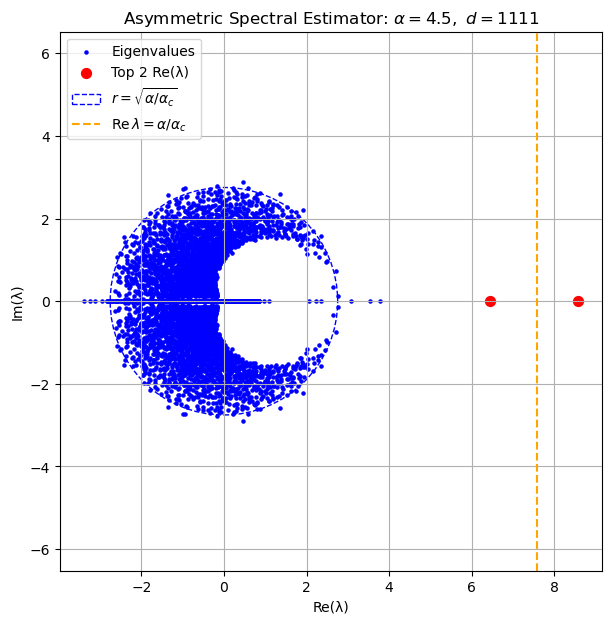

In [2]:
import os
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import kv as besselk

# 固定随机种子（可复现性）
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)

set_seed(42)

# 配置参数
n = 5000  # 样本数
p = 2      # 子空间维度
alpha = 4.5
alpha_c = 0.59375
d = int(n / alpha)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Step 1: 生成输入矩阵 X ∈ ℝ^{n × d}
X = torch.randn(n, d, device=device) / np.sqrt(d)

# Step 2: 构造信号子空间 W* 和观测 Z = X W*
W_star = torch.randn(d, p, device=device)
Z = X @ W_star
z1, z2 = Z[:, 0], Z[:, 1]
y = z1 * z2  # link function: y = z1 * z2

# Step 3: 计算预处理函数 G(y) ∈ ℝ^{n × p × p}
y_cpu = y.detach().cpu().numpy()
abs_y = np.abs(y_cpu)
K1 = besselk(1, abs_y)
K0 = besselk(0, abs_y)
lambda_y = abs_y * (K1 / K0) - 1
lambda_y[np.isnan(lambda_y)] = 0  # 数值稳定处理

# 构造 G(y): 每个样本一个 2x2 对称矩阵
G_y_np = np.zeros((n, p, p), dtype=np.float32)
G_y_np[:, 0, 0] = lambda_y
G_y_np[:, 1, 1] = lambda_y
G_y_np[:, 0, 1] = y_cpu
G_y_np[:, 1, 0] = y_cpu
G_y = torch.tensor(G_y_np, device=device)

# Step 4: 构造非对称谱矩阵 L ∈ ℝ^{np × np}
XXT = X @ X.T  # shape: (n, n)
XXT.fill_diagonal_(0.0)  # 去掉主对角线

# 构造谱矩阵 L 的 (iμ, jν) 元素
A = XXT[:, :, None, None]            # shape: (n, n, 1, 1)
G_broadcast = G_y[None, :, :, :]     # shape: (1, n, p, p)
L_blocks = A * G_broadcast           # shape: (n, n, p, p)
L = L_blocks.permute(0, 2, 1, 3).reshape(n * p, n * p)  # shape: (np, np)
print(f"L shape: {L.shape}, L device: {L.device}")

# Step 5: 计算特征值（在 GPU 上）并绘图
eigvals = torch.linalg.eigvals(L)
eigvals_np = eigvals.detach().cpu().numpy()
eigvals_real = eigvals_np.real

# 获取最大两个实部的特征值索引和特征值
top2_idx = np.argsort(eigvals_real)[-2:]
top2_vals = eigvals_np[top2_idx]

# 可视化谱图
plt.figure(figsize=(7, 7))
plt.scatter(eigvals_np.real, eigvals_np.imag, s=5, color='blue', label='Eigenvalues')
plt.scatter(top2_vals.real, top2_vals.imag, color='red', s=50, label='Top 2 Re(λ)')

# 理论谱圆半径和跳跃阈值
r = np.sqrt(alpha / alpha_c)
thresh = alpha / alpha_c

circle = plt.Circle((0, 0), r, color='blue', fill=False, linestyle='--',
                    label=rf'$r = \sqrt{{\alpha / \alpha_c}}$')
plt.gca().add_artist(circle)
plt.axvline(x=thresh, color='orange', linestyle='--',
            label=rf'$\mathrm{{Re}}\,\lambda = \alpha / \alpha_c$')

# 图形设置
plt.xlabel('Re(λ)')
plt.ylabel('Im(λ)')
plt.title(rf'Asymmetric Spectral Estimator: $\alpha = {alpha},\ d = {d}$')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()


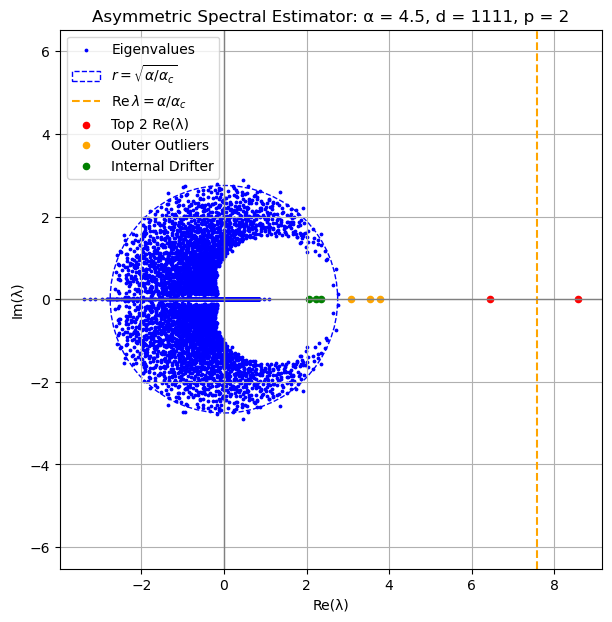

In [4]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from numpy.linalg import norm
from scipy.linalg import qr
import pandas as pd

# ===============================
# Overlap 计算函数
# ===============================
def generalized_overlap_corrected(W_star, eigvals_np, eigvecs_np, target_vals, label_prefix, X):
    results = []
    d = W_star.shape[0]
    W_orth, _ = qr(W_star, mode='economic')  # 正交化 W_star
    X_cpu = X.cpu().numpy().T  # shape: (d, n)

    for i, val in enumerate(target_vals):
        idx = np.argmin(np.abs(eigvals_np - val))
        v_hat = eigvecs_np[:, idx]  # shape: (n*p,)
        V = v_hat.reshape(-1, 2)    # shape: (n, 2)

        U = X_cpu @ V  # shape: (d, 2)
        for j in range(2):
            u = U[:, j]
            u_hat = u / norm(u)
            q = norm(W_orth.T @ u_hat)**2
            results.append((f"{label_prefix}{i+1}-{j+1}", val, q))
    return results

# ===============================
# 假设已有以下变量
# ===============================
# - L: 谱矩阵 (torch.complex)
# - alpha, alpha_c: 超参数
# - W_star: 真实信号子空间 (torch.tensor, shape d×2)
# - X: 输入矩阵 (torch.tensor, shape n×d)

eigvals, eigvecs = torch.linalg.eig(L)
eigvals_np = eigvals.cpu().numpy()
eigvecs_np = eigvecs.cpu().numpy()
W_star_np = W_star.cpu().numpy()
d = W_star_np.shape[0]

R = np.sqrt(alpha / alpha_c)        # 蓝色圆圈半径
thresh_ext = alpha / alpha_c        # 橙色虚线位置

# ===============================
# 特征值分类
# ===============================
real_mask = np.isclose(eigvals_np.imag, 0.0, atol=1e-6)
eigvals_real_only = eigvals_np[real_mask]
real_parts = eigvals_real_only.real

# Top 实部谱点选取
top10_real_idx = np.argsort(real_parts)[-10:]
top10_real_vals = eigvals_real_only[top10_real_idx]

# 红色：实部最大2个
red_vals = top10_real_vals[-2:]
rest_vals = top10_real_vals[:-2]

# 分类橙色 & 圆内候选绿色点
orange_vals = []
green_candidates = []
for val in rest_vals:
    if R < val.real < thresh_ext:
        orange_vals.append(val)
    elif val.real < R:
        green_candidates.append(val)

# ===============================
# 绿色点选取：实轴上，圆圈内，Re 最大的两个
# ===============================
green_vals = []
inside_real_mask = np.logical_and(
    np.abs(eigvals_np) <= R,
    np.isclose(eigvals_np.imag, 0.0, atol=1e-6)
)
eigvals_real_inside = eigvals_np[inside_real_mask]

if eigvals_real_inside.size >= 2:
    top2_idx = np.argsort(eigvals_real_inside.real)[-3:]
    green_vals = [eigvals_real_inside[i] for i in top2_idx]
elif eigvals_real_inside.size == 1:
    green_vals = [eigvals_real_inside[0]]

# ===============================
# 可视化绘图
# ===============================
plt.figure(figsize=(7, 7))
plt.scatter(eigvals_np.real, eigvals_np.imag, color="blue", s=3, label="Eigenvalues")

circle = plt.Circle((0, 0), R, color="blue", linestyle="--", fill=False, label=r"$r = \sqrt{\alpha/\alpha_c}$")
plt.gca().add_artist(circle)
plt.axvline(thresh_ext, color="orange", linestyle="--", label=r"$\mathrm{Re}\,\lambda = \alpha/\alpha_c$")

plt.scatter([z.real for z in red_vals], [z.imag for z in red_vals], color="red", s=20, label="Top 2 Re(λ)")
plt.scatter([z.real for z in orange_vals], [z.imag for z in orange_vals], color="orange", s=20, label="Outer Outliers")

# 修正后的绿色绘制
if len(green_vals) > 0:
    plt.scatter([z.real for z in green_vals], [z.imag for z in green_vals], color="green", s=20, label="Internal Drifter")

plt.axhline(0, color='gray', linewidth=1)
plt.axvline(0, color='gray', linewidth=1)
plt.xlabel("Re(λ)")
plt.ylabel("Im(λ)")
plt.title(f"Asymmetric Spectral Estimator: α = {alpha}, d = {d}, p = 2")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.show()


In [6]:
# ===============================
# 计算 overlap
# ===============================
results_red = generalized_overlap_corrected(W_star_np, eigvals_np, eigvecs_np, red_vals, "Red", X)
results_orange = generalized_overlap_corrected(W_star_np, eigvals_np, eigvecs_np, orange_vals, "Orange", X)
results_green = generalized_overlap_corrected(W_star_np, eigvals_np, eigvecs_np, green_vals, "Green", X)

# 合并所有结果
df_overlap = pd.DataFrame(results_red + results_orange + results_green,
                          columns=["Label", "Eigenvalue", "Overlap_q"])
df_overlap = df_overlap.sort_values("Overlap_q", ascending=False).reset_index(drop=True)

print(df_overlap)


        Label          Eigenvalue  Overlap_q
0      Red1-1  6.449202+0.000000j   0.372715
1      Red1-2  6.449202+0.000000j   0.372715
2      Red2-2  8.560905+0.000000j   0.336446
3      Red2-1  8.560905+0.000000j   0.336446
4    Green2-2  2.230835+0.000000j   0.001245
5    Green2-1  2.230835+0.000000j   0.001245
6   Orange1-1  3.074945+0.000000j   0.000564
7   Orange1-2  3.074945+0.000000j   0.000564
8   Orange2-2  3.542561+0.000000j   0.000426
9   Orange2-1  3.542561+0.000000j   0.000426
10   Green1-2  2.068187+0.000000j   0.000181
11   Green1-1  2.068187+0.000000j   0.000181
12   Green3-1  2.348005+0.000000j   0.000138
13   Green3-2  2.348005+0.000000j   0.000138
14  Orange3-1  3.785577+0.000000j   0.000071
15  Orange3-2  3.785577+0.000000j   0.000071


In [8]:
import numpy as np
import pandas as pd
from numpy.linalg import norm
from itertools import combinations
from scipy.linalg import qr

# === 第二步：定义 rank-2 overlap 计算函数（不使用 Pt 编号）===
def rank2_overlap_from_labels(W_star, eigvals_np, eigvecs_np, df_result, X):
    results = []
    d = W_star.shape[0]
    W_orth, _ = qr(W_star, mode='economic')
    X_cpu = X.cpu().numpy().T  # shape (d, n)

    v_map = {}  # Label -> 向量

    for i, row in enumerate(df_result.itertuples()):
        label = row.Label
        val = row.Eigenvalue
        idx = np.argmin(np.abs(eigvals_np - val))
        v_hat = eigvecs_np[:, idx]
        V = v_hat.reshape(-1, 2)  # shape: (n, 2)
        j = 0 if '1' in label[-3:] else 1  # 通过 Label 末尾判断是第1还是第2个方向
        v_map[label] = V[:, j]

    # 枚举所有不重复组合
    for (id1, v1), (id2, v2) in combinations(v_map.items(), 2):
        U = X_cpu @ np.column_stack([v1, v2])  # shape (d, 2)
        U, _ = qr(U, mode='economic')  # orthonormalize
        q = np.linalg.norm(W_orth.T @ U, ord='fro')**2  # Frobenius norm squared
        results.append((f"{id1} + {id2}", q))

    return pd.DataFrame(results, columns=["ComboLabel", "Rank2_Overlap_q"])\
             .sort_values("Rank2_Overlap_q", ascending=False)\
             .reset_index(drop=True)


# === 第三步：调用函数 ===
# 假设以下变量已存在：
# - W_star_np: (d, 2)
# - eigvals_np, eigvecs_np: 特征值与特征向量（来自 torch）
# - df_result: 包含单点标签 ["Label", "Eigenvalue", "Overlap_q"]
# - X: 输入矩阵 (n, d)

df_rank2 = rank2_overlap_from_labels(W_star_np, eigvals_np, eigvecs_np, df_overlap, X)

# === 第四步：输出结果 ===
pd.set_option("display.max_rows", None)
print(df_rank2)


                ComboLabel  Rank2_Overlap_q
0          Red1-1 + Red2-1         0.709643
1          Red1-2 + Red2-1         0.709643
2          Red1-2 + Red2-2         0.709643
3          Red1-1 + Red2-2         0.709643
4          Red2-2 + Red2-1         0.448708
5        Red1-1 + Green2-2         0.374057
6        Red1-1 + Green2-1         0.374057
7        Red1-2 + Green2-1         0.374057
8        Red1-2 + Green2-2         0.374057
9          Red1-1 + Red1-2         0.373329
10      Red1-1 + Orange1-1         0.373059
11      Red1-1 + Orange1-2         0.373059
12      Red1-2 + Orange1-2         0.373059
13      Red1-2 + Orange1-1         0.373059
14      Red1-2 + Orange2-2         0.373034
15      Red1-2 + Orange2-1         0.373034
16      Red1-1 + Orange2-1         0.373034
17      Red1-1 + Orange2-2         0.373034
18      Red1-1 + Orange3-2         0.373011
19      Red1-1 + Orange3-1         0.373011
20      Red1-2 + Orange3-1         0.373011
21      Red1-2 + Orange3-2      

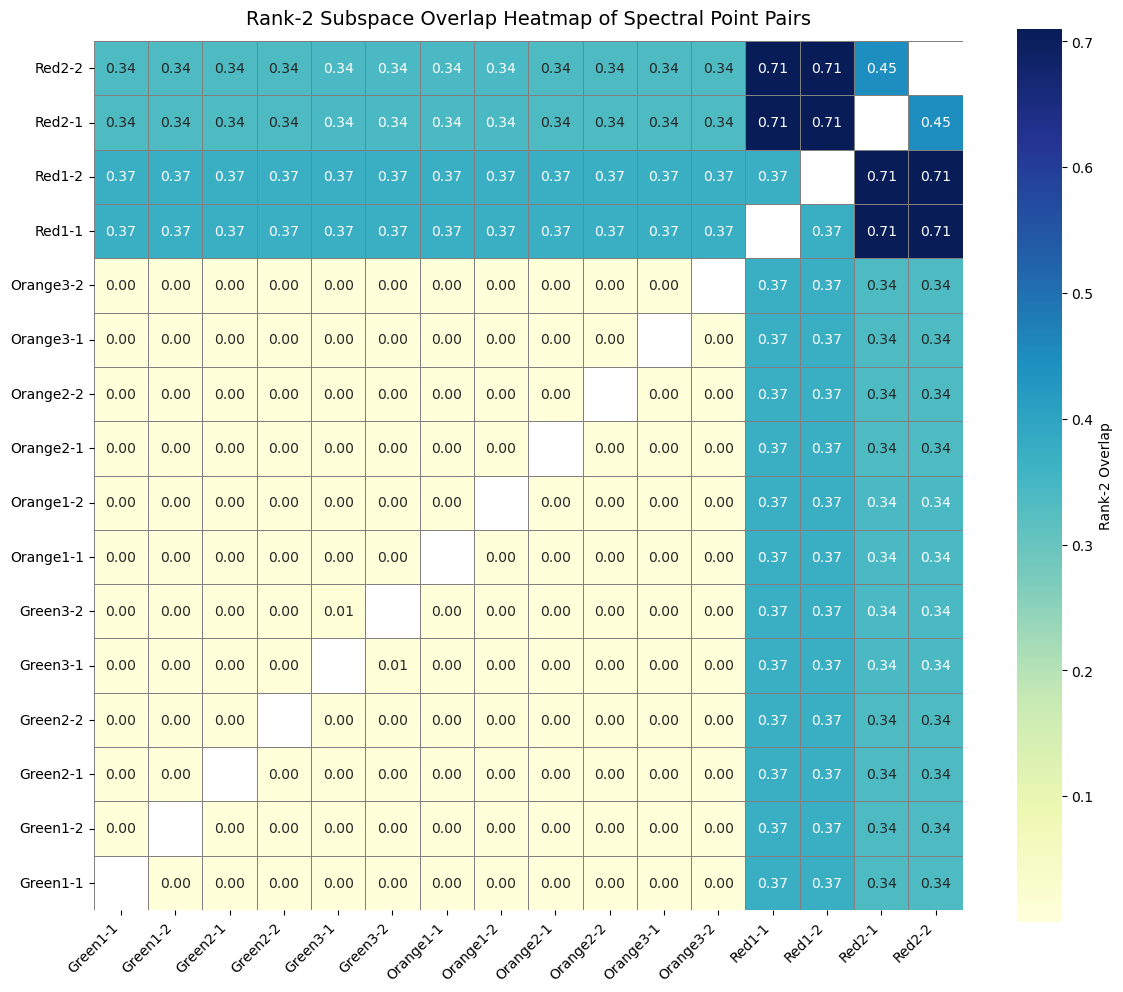

In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# 假设你已有 df_rank2，其中包含：
# - "ComboLabel": e.g. "Green2-1 + Red2-2"
# - "Rank2_Overlap_q": 数值

# === Step 1: 提取所有唯一的点名 ===
all_labels = sorted(set(sum([label.split(' + ') for label in df_rank2['ComboLabel']], [])))

# 创建空的对称矩阵
heatmap_matrix = pd.DataFrame(np.nan, index=all_labels, columns=all_labels)

# 填入值
for _, row in df_rank2.iterrows():
    a, b = row['ComboLabel'].split(' + ')
    heatmap_matrix.loc[a, b] = row['Rank2_Overlap_q']
    heatmap_matrix.loc[b, a] = row['Rank2_Overlap_q']

# 对角线设置为 NaN（不绘制）
np.fill_diagonal(heatmap_matrix.values, np.nan)

# === Step 2: 找出 Top-5 的组合 ===
top5 = df_rank2.nlargest(5, 'Rank2_Overlap_q')

# === Step 3: 绘制热力图 ===
plt.figure(figsize=(12, 10))
ax = sns.heatmap(heatmap_matrix, annot=True, fmt=".2f", cmap="YlGnBu", square=True,
                 cbar_kws={'label': 'Rank-2 Overlap'}, linewidths=0.5, linecolor='gray')

# 标题设置
plt.title("Rank-2 Subspace Overlap Heatmap of Spectral Point Pairs", fontsize=14, pad=12)

# === Step 4: 添加红框标记 Top-5 ===


# 坐标轴标签旋转
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
ax.invert_yaxis()  # ✅ 反转纵轴以符合学术规范

# 紧凑布局
plt.tight_layout()
plt.show()
